In [1]:
import pandas as pd
import numpy as np
import typing
save_plot = True
debug = True
data_dir = '../data/dianli.xlsx'
data = pd.read_excel(data_dir,nrows=1000 if debug else None)

In [3]:
raw_data_copy = data.copy()
raw_data_copy.columns = ['date', 'hour',
                         'f1', 'f2', 'f3', 'f4', 'f5', 'target']
raw_data_copy = raw_data_copy[['f1', 'f2', 'f3', 'f4', 'f5', 'target']]
targ_cols = ("target",)  # NDX是我们需要预测的值

,f1,f2,f3,f4,f5,target
0,23.9,21.65,22.4,87.5,19.67,8013.27833


In [8]:
# 数据预处理
class TrainConfig(typing.NamedTuple):
    T: int
    train_size: int
    batch_size: int
    loss_func: typing.Callable


class TrainData(typing.NamedTuple):
    feats: np.ndarray
    targs: np.ndarray
    
from sklearn.preprocessing import StandardScaler
def read2Dataloader(data,col_names):
    scaler = StandardScaler().fit(data)
    proc_dat = scaler.transform(data)
    mask = np.ones(proc_dat.shape[1],dtype=bool)
    dat_cols = list(data.columns)
    for col_name in col_names:
        mask[dat_cols.index(col_name)] = False
    feats = proc_dat[:,mask]
    targs = proc_dat[:,~mask]
    return TrainData(feats,targs)
# 返回特征
trainData = read2Dataloader(raw_data_copy,targ_cols)

In [119]:
'''
基本网络类型
'''
import torch.nn as nn
import json
from torch import optim
import collections
import typing
import torch.nn.functional as F
'''
初始化简单的lstm网络
'''
RnnNet = collections.namedtuple("RnnNet",["rnn","rnn_optimizer"])
class Lstm(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers , output_size , dropout, batch_first):
        super(Lstm, self).__init__()
        # lstm的输入 #batch,seq_len, input_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first

        self.rnn = nn.GRU(input_size=input_size,hidden_size=hidden_size,
                        num_layers=num_layers,batch_first=True)
        # self.rnn = nn.LSTM(input_size=self.input_size, 
        #                    hidden_size=self.hidden_size, 
        #                    num_layers=self.num_layers, 
        #                    batch_first=self.batch_first, 
        #                    dropout=self.dropout)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # out, (hidden, cell) = self.rnn(x)  # x.shape : batch, seq_len, hidden_size , hn.shape and cn.shape : num_layes * direction_numbers, batch, hidden_size
        # # a, b, c = hidden.shape
        # # out = self.linear(hidden.reshape(a * b, c))
        # out = self.linear(hidden)
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))    
        # Propagate input through GRU
        ula, h_out  = self.rnn(x, h_0)
        h_out = h_out.view(-1, self.hidden_size)
        out = F.relu(self.linear(h_out))
        return out


In [121]:
def rnn(train_data: TrainData, n_targs: int, hidden_size:int, T:int, learning_rate=0.001, batch_size=128):

    # 定义配置器 T=>滑窗长度 截取前70%的数据作为训练集
    train_cfg = TrainConfig(
        T, int(train_data.feats.shape[0] * 0.7), batch_size, nn.MSELoss())
    print('train size: ',train_cfg.train_size)


    input_size = train_data.feats.shape[1] 
    print('input size: ',input_size +1)
    # 初始化网络结构
    rnn_args = {
        "input_size" :input_size + 1,
        "hidden_size" : hidden_size,
        "num_layers" : 1,
        "output_size" : 1,
        "dropout" : 0,
        "batch_first":True
    }
    print ("run args: ", rnn_args)
    rnn  = Lstm(**rnn_args)
    with open( ('../data/lstm.json'),"w") as fi: 
        json.dump(rnn_args,fi,indent=4)

    rnn_optimizer = optim.Adam(
        params=rnn.parameters(),
        lr=learning_rate
    )
    # 返回的网络结构
    rnn_net = RnnNet(
        rnn,rnn_optimizer
    )
    return train_cfg, rnn_net

In [122]:
# 初始化模型参数
init_args = {"batch_size": 128, "T": 10}
rnn_kwargs = init_args
config, model = rnn(trainData, n_targs=len(targ_cols),hidden_size=64,T=10,learning_rate=.001,batch_size=128)

train size:  700
input size:  6
run args:  {'input_size': 6, 'hidden_size': 64, 'num_layers': 1, 'output_size': 1, 'dropout': 0, 'batch_first': True}


In [128]:
# 平滑处理序列 开始训练
import torch
from torch.autograd import Variable
def PrepareData(batch_idx,t_cfg,train_data):
    feats = np.zeros((len(batch_idx), t_cfg.T - 1 , train_data.feats.shape[1]))
    y_history = np.zeros((len(batch_idx) ,t_cfg.T - 1 , train_data.targs.shape[1]))
    y_target = train_data.targs[batch_idx + t_cfg.T]
    # 获取采样的batch_id的下标和值
    # 获取特征和标签的相应下标值
    for b_i, b_idx in enumerate(batch_idx):
        b_slc = slice(b_idx, b_idx + t_cfg.T-1)
        #print('b_i',b_i,'b_slc',b_slc)
        feats[b_i, :, :] = train_data.feats[b_slc, :]
        #print(y_history[b_i : ].shape,train_data.targs[b_slc].shape)
        y_history[b_i :] = train_data.targs[b_slc]

    return feats, y_history, y_target


def rnn_train_iteration(t_net: RnnNet, loss_func: typing.Callable, X, y_history, y_target):
    input_data = np.append(X, y_history, axis=2)
    data1 = torch.from_numpy(input_data).to(torch.float32)
    print('input shape: ',data1.shape)
    pred = t_net.rnn(Variable(data1))
    print('pred shape: ',pred.shape)
    #pred = pred[0, :, :]
    label = torch.from_numpy(y_target).to(torch.float32).unsqueeze(1)
    print('label shape: ',label.shape)
    loss = loss_func(pred, label)
    t_net.rnn_optimizer.zero_grad()
    loss.backward()
    t_net.rnn_optimizer.step()
    return loss.item()


In [129]:
'''
utils
'''

import logging
import os

import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def setup_log(tag='VOC_TOPICS'):
    # create logger
    logger = logging.getLogger(tag)
    # logger.handlers = []
    logger.propagate = False
    logger.setLevel(logging.DEBUG)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    # logger.handlers = []
    logger.addHandler(ch)
    return logger


def save_or_show_plot(file_nm: str, save: bool):
    if save:
        plt.savefig(file_nm)
    else:
        plt.show()


def numpy_to_tvar(x):
    return Variable(torch.from_numpy(x).type(torch.FloatTensor).to(device))


from sklearn.utils.validation import check_consistent_length, check_array

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    """Mean absolute percentage error regression loss.
    Note here that we do not represent the output as a percentage in range
    [0, 100]. Instead, we represent it in range [0, 1/eps]. Read more in the
    :ref:`User Guide <mean_absolute_percentage_error>`.
    .. versionadded:: 0.24
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput : {'raw_values', 'uniform_average'} or array-like
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        If input is list then the shape must be (n_outputs,).
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.
    Returns
    -------
    loss : float or ndarray of floats in the range [0, 1/eps]
        If multioutput is 'raw_values', then mean absolute percentage error
        is returned for each output separately.
        If multioutput is 'uniform_average' or an ndarray of weights, then the
        weighted average of all output errors is returned.
        MAPE output is non-negative floating point. The best value is 0.0.
        But note the fact that bad predictions can lead to arbitarily large
        MAPE values, especially if some y_true values are very close to zero.
        Note that we return a large value instead of `inf` when y_true is zero.
    Examples
    --------
    >>> from sklearn.metrics import mean_absolute_percentage_error
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.3273...
    >>> y_true = [[0.5, 1], [-1, 1], [7, -6]]
    >>> y_pred = [[0, 2], [-1, 2], [8, -5]]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.5515...
    >>> mean_absolute_percentage_error(y_true, y_pred, multioutput=[0.3, 0.7])
    0.6198...
    """
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    """Check that y_true and y_pred belong to the same regression task.
    Parameters
    ----------
    y_true : array-like
    y_pred : array-like
    multioutput : array-like or string in ['raw_values', uniform_average',
        'variance_weighted'] or None
        None is accepted due to backward compatibility of r2_score().
    Returns
    -------
    type_true : one of {'continuous', continuous-multioutput'}
        The type of the true target data, as output by
        'utils.multiclass.type_of_target'.
    y_true : array-like of shape (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples, n_outputs)
        Estimated target values.
    multioutput : array-like of shape (n_outputs) or string in ['raw_values',
        uniform_average', 'variance_weighted'] or None
        Custom output weights if ``multioutput`` is array-like or
        just the corresponding argument if ``multioutput`` is a
        correct keyword.
    dtype : str or list, default="numeric"
        the dtype argument passed to check_array.
    """
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput


In [130]:
import matplotlib.pyplot as plt
logger = setup_log()
from sklearn.metrics import mean_squared_error,mean_absolute_error

model params:  Lstm(
  (rnn): GRU(6, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
iter_per_epoch:  700 128 6
iter_losses:  (180,)
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])


D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])


D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([50, 1, 1])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
2021-09-04 14:34:02,394 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.075, val loss: 0.7779649634460997.
2021-09-04 14:34:02,394 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.075, val loss: 0.7779649634460997.
2021-09-04 14:34:02,394 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.075, val loss: 0.7779649634460997.
2021-09-04 14:34:02,394 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.075, val loss: 0.7779649634460997.
2021-09-04 14:34:02,394 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.075, val loss: 0.7779649634460997.
2021-09-04 14:34:02,394 - VOC_TOPICS - INFO - Epoch 0, train loss: 1.075, val loss: 0.7779649634460997.
2021-09-04 14:34:02,394 - VOC_TOPIC

rmse:  0.9068714107631249
mae:  0.7779649634460997
mape:  0.998814731255833
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shap

D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([50, 1, 1])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128

2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10, train loss: 1.075, val loss: 0.7792314105344704.
2021-09-04 14:34:03,784 - VOC_TOPICS - INFO - Epoch 10,

rmse:  0.9083906533789514
mae:  0.7792314105344704
mape:  1.0
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape: 

D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([50, 1, 1])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([

2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20, train loss: 1.088, val loss: 0.7792314105344704.
2021-09-04 14:34:04,496 - VOC_TOPICS - INFO - Epoch 20,


label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape: 

D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape: 

D:\anaconda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([50, 1, 1])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([50, 9, 6])
pred shape:  torch.Size([50, 1])
label shape:  torch.Size([50, 1, 1])
input shape:  torch.Size([128, 9, 6])
pred shape:  torch.Size([128, 1])
label shape:  torch.Size([128, 1, 1])
input shape:  torch.Size([128

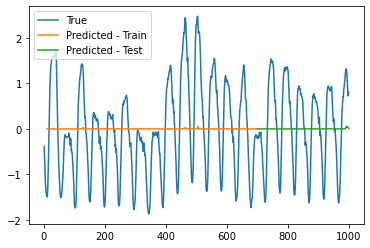

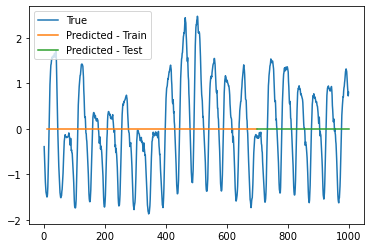

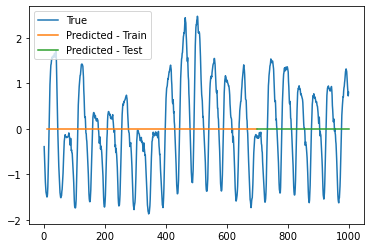

In [131]:


def adjust_learning_rate(net: RnnNet, n_iter: int):
    # TODO: Where did this Learning Rate adjustment schedule come from?
    # Should be modified to use Cosine Annealing with warm restarts https://www.jeremyjordan.me/nn-learning-rate/
    if n_iter % 10000 == 0 and n_iter > 0:
        for enc_params, dec_params in zip(net.enc_opt.param_groups, net.dec_opt.param_groups):
            enc_params['lr'] = enc_params['lr'] * 0.9
            dec_params['lr'] = dec_params['lr'] * 0.9

'''
预测代码
'''
def predict(t_net: RnnNet, t_dat: TrainData, train_size: int, batch_size: int, T: int, on_train=False):
    # 设置输出的维度
    out_size = t_dat.targs.shape[1]

    if on_train:
        y_pred = np.zeros((train_size - T + 1, out_size))
    else:
        # 如果是测试就设置输出的长度为测试数据长
        y_pred = np.zeros((t_dat.feats.shape[0] - train_size, out_size))

    '''
    以每一次batch大小重新批量预测数据
    '''
    for y_i in range(0, len(y_pred), batch_size):
        y_slc = slice(y_i, y_i + batch_size)
        batch_idx = range(len(y_pred))[y_slc]
        X = np.zeros((len(batch_idx), T - 1, t_dat.feats.shape[1] ))
        y_history = np.zeros((len(batch_idx), T - 1, t_dat.targs.shape[1]))

        for b_i, b_idx in enumerate(batch_idx):
            if on_train:
                idx = range(b_idx, b_idx + T - 1)
            else:
                idx = range(b_idx + train_size - T, b_idx + train_size - 1)

            X[b_i, :, :] = t_dat.feats[idx, :]
            y_history[b_i, :] = t_dat.targs[idx]

        '''
        在这里重新合并rnn数据格式
        '''
        input_data = torch.from_numpy(np.append(X, y_history, axis=2)).to(torch.float32)
        y_pred[y_slc] = t_net.rnn(Variable(input_data)).detach().numpy()
    return y_pred


def train_rnn(net: RnnNet, train_data: TrainData, t_cfg: TrainConfig, n_epochs, save_plots=False):
    # 完成所有数据训练的迭代次数
    iter_per_epoch = int(np.ceil(t_cfg.train_size * 1. / t_cfg.batch_size))
    print('iter_per_epoch: ',t_cfg.train_size,t_cfg.batch_size,iter_per_epoch)
    # 存储损失值列表
    iter_losses = np.zeros(n_epochs * iter_per_epoch)
    print('iter_losses: ',iter_losses.shape)
    # 存储每次epoch的损失值
    epoch_losses = np.zeros(n_epochs)
   
    n_iter = 0

    for e_i in range(n_epochs):
        # 随机生成
        perm_idx = np.random.permutation(t_cfg.train_size - t_cfg.T)

        # 循环迭代 每次迭代的步长为batch_size，每次选择batch_size大小的数据进行预测
        for t_i in range(0, t_cfg.train_size, t_cfg.batch_size):
            # 随机选择索引列
            batch_idx = perm_idx[t_i:(t_i + t_cfg.batch_size)]
            # TODO 闭包函数，返回处理好的特征，历史数据，预测目标值
            feats,y_history,y_target = PrepareData(batch_idx,t_cfg,train_data)
            # data,label = ProcessData(feats,y_history,y_target)
            # 使用新的训练函数
            loss = rnn_train_iteration(net, t_cfg.loss_func,
                                       feats, y_history, y_target)
                                    
            iter_losses[e_i * iter_per_epoch + t_i // t_cfg.batch_size] = loss
            # if (j / t_cfg.batch_size) % 50 == 0:
            #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / t_cfg.batch_size, loss)
            n_iter += 1
            adjust_learning_rate(net, n_iter)
            
        epoch_losses[e_i] = np.mean(
            iter_losses[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)])

        if e_i % 10 == 0:
            with torch.no_grad():
                y_test_pred = predict(net, train_data,
                                    t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                    on_train=False)
                # TODO: make this MSE and make it work for multiple inputs
                val_loss = y_test_pred - train_data.targs[t_cfg.train_size:]
                logger.info(
                    f"Epoch {e_i:d}, train loss: {epoch_losses[e_i]:3.3f}, val loss: {np.mean(np.abs(val_loss))}.")
                
                y_train_pred = predict(net, train_data,
                                    t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                    on_train=True)
                plt.figure()
                plt.plot(range(1, 1 + len(train_data.targs)), train_data.targs,
                        label="True")
                plt.plot(range(t_cfg.T, len(y_train_pred) + t_cfg.T), y_train_pred,
                        label='Predicted - Train')
                plt.plot(range(t_cfg.T + len(y_train_pred), len(train_data.targs) + 1), y_test_pred,
                        label='Predicted - Test')
                plt.legend(loc='upper left')

                # print(1,1 + len(train_data.targs))
                # print(t_cfg.T,len(y_train_pred) + t_cfg.T)
                # print(t_cfg.T + len(y_train_pred),len(train_data.targs) +1)


                # todo 计算三者最后的MSE MAE MAPE
                y_test_list = list(y_test_pred)
                y_real = list(train_data.targs)[t_cfg.T + len(y_train_pred)-1 :len(train_data.targs) ]
                # print(len(y_real),len(y_test_list))


                print('rmse: ',np.sqrt(mean_squared_error(y_real,y_test_list)))
                print('mae: ', mean_absolute_error(y_real, y_test_list))
                print('mape: ', mean_absolute_percentage_error(y_real, y_test_list))
                save_or_show_plot(f"pred_rnn{e_i}.png", save_plots)

    print('epoch_loss',epoch_losses)
    print('训练结束')
    return iter_losses, epoch_losses

print('model params: ',model.rnn)
iter_loss, epoch_loss = train_rnn(
            model, trainData, config, n_epochs=30, save_plots=True)